# NFL New England Play prediction

https://towardsdatascience.com/how-to-win-in-the-nfl-b2b441ca8f5d

In [1]:
import pandas as pd
import matplotlib as plt
from sklearn import preprocessing

In [2]:
df = pd.read_csv('reg_pbp_2018.csv')


C:\Users\robin\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (42,167,168,169,170,179,180,183,184,189,190,191,192,199,200,201,202,203,204,205,206,208,210,212,227,228,229,230,231,232,233,234,235,237,238,239,241,242,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape


(45156, 256)

In [4]:
#filter rows
nedf = df[(df.posteam=='NE') & (df.down.isin([1.0, 2.0, 3.0, 4.0])) & ((df.play_type=='run') | (df.play_type == 'pass'))]

In [5]:
#filter columns
nedf = nedf[['game_seconds_remaining', 'yardline_100', 'down', 'ydstogo', 'shotgun', 'score_differential', 'play_type', 'pass_length', 'pass_location', 'run_location']]
nedf.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location
744,3600.0,75.0,1.0,10,0,0.0,run,NaN,NaN,middle
745,3565.0,69.0,2.0,4,1,0.0,run,NaN,NaN,middle
746,3529.0,68.0,3.0,3,1,0.0,run,NaN,NaN,middle
749,3478.0,19.0,1.0,10,1,0.0,pass,deep,right,NaN
750,3474.0,19.0,2.0,10,0,0.0,run,NaN,NaN,left


In [6]:
import numpy as np
def get_full_play_type(play):
    play_type, pass_location, run_location = play
    if(play_type == 'run'):
        return play_type+'_'+ run_location
    else:
        return play_type+'_'+ pass_location
nedf = nedf.replace(np.nan, 'unknown', regex=True)    
nedf['full_play_type'] = nedf[['play_type','pass_location', 'run_location']].apply(get_full_play_type, axis=1)
nedf = nedf[(nedf.full_play_type.isin(['pass_left', 'pass_middle','pass_right','run_left', 'run_middle', 'run_right']))]

In [7]:
nedf.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location,full_play_type
744,3600.0,75.0,1.0,10,0,0.0,run,unknown,unknown,middle,run_middle
745,3565.0,69.0,2.0,4,1,0.0,run,unknown,unknown,middle,run_middle
746,3529.0,68.0,3.0,3,1,0.0,run,unknown,unknown,middle,run_middle
749,3478.0,19.0,1.0,10,1,0.0,pass,deep,right,unknown,pass_right
750,3474.0,19.0,2.0,10,0,0.0,run,unknown,unknown,left,run_left


In [8]:
nedf.groupby(['full_play_type']).count()[['play_type']].plot(kind='bar')

In [9]:
nedf.groupby(['full_play_type']).count()[['play_type']].apply(lambda x:100 * x / float(x.sum()))

,play_type
full_play_type,
pass_left,21.789883
pass_middle,14.299611
pass_right,19.357977
run_left,16.536965
run_middle,13.813230
run_right,14.202335


In [10]:
le = preprocessing.LabelEncoder()
le.fit(nedf.full_play_type)
nedf['full_play_type_code'] = le.transform(nedf['full_play_type'])

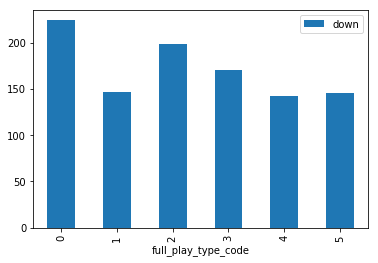

In [11]:
nedf.groupby(['full_play_type_code']).count()[['down']].plot(kind='bar')

In [12]:
def bucketize(val, size, count):
    i=0
    for i in range(count):
        if val <= (i+1)*size:
            return i
    return i
def bucketize_df(df):
    df['ydstogo'] = [bucketize(x, 4, 5) for x in df['ydstogo']]
    return df
nedf = bucketize_df(nedf)

In [13]:
nedf = pd.concat([nedf, pd.get_dummies(nedf['down'], prefix='down')], axis=1)
nedf = pd.concat([nedf, pd.get_dummies(nedf['ydstogo'], prefix='ydstogo')], axis=1)

In [14]:
nedf.describe()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,full_play_type_code,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,ydstogo_1,ydstogo_2,ydstogo_3,ydstogo_4
count,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000
mean,1814.434825,48.938716,1.742218,1.495136,0.465953,2.792802,2.288911,0.466926,0.337549,0.181907,0.013619,0.199416,0.189689,0.548638,0.040856,0.021401
std,1036.414910,25.123398,0.798421,0.927234,0.499082,10.489521,1.711748,0.499148,0.473104,0.385955,0.115958,0.399756,0.392246,0.497871,0.198053,0.144787
min,17.000000,1.000000,1.000000,0.000000,0.000000,-24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,948.750000,29.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1832.000000,52.000000,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2700.000000,70.000000,2.000000,2.000000,1.000000,8.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3600.000000,98.000000,4.000000,4.000000,1.000000,38.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
nedf['game_seconds_remaining']/=3600
nedf['yardline_100']/=100
nedf['score_differential']=(nedf['score_differential']+50)/100

In [16]:
from sklearn.model_selection import train_test_split
#select important columns for input
X=nedf[['yardline_100', 'shotgun', 'score_differential', 'game_seconds_remaining', 'down_1.0', 'down_2.0', 'down_3.0', 'down_4.0','ydstogo_0','ydstogo_1','ydstogo_2','ydstogo_3','ydstogo_4']]
#select result column for output
Y=nedf['full_play_type_code']
#split data for train and test
train_x, test_x, train_y, test_y = train_test_split(X, Y, random_state = 0)

In [17]:
from sklearn.ensemble import RandomForestClassifier
the_clf=RandomForestClassifier(max_depth=8, n_estimators=64)
the_clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=64,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
from sklearn.metrics import accuracy_score
pred = the_clf.predict(test_x)
acc =accuracy_score(test_y, pred)
print(acc)

0.245136186770428
